# Prediction on the full timeseries data

In [1]:
default_wrkspc = dir()

In [2]:
%%bash
echo "Current branch"
git branch

Current branch
* explore_appr_retr
  master


In [3]:
%load_ext watermark
%watermark

2020-10-09T00:27:10-04:00

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-1093-oem
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from src.data import *

## Load the trained model

In [5]:
model = tf.keras.models.load_model("../../models/CustomGRU_ROI316_withShiftedSegments.h5")

In [6]:
subj = 'CON121'
data_path='../../data'
#download(subj)

In [7]:
%%bash

# Extract ROI timeseries
source ~/.bashrc

subj=CON121
data_path='../../data'
if [ 1 -eq 0 ]; then
cortical_mask='${data_path}/raw/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz'
subcortical_mask='${data_path}/raw/masks/00b-subcortical_ROIs.nii.gz'

3dROIstats -quiet -mask $cortical_mask ${data_path}/external/${subj}/${subj}_EP_TR_MNI_2mm_SI_denoised_NoBaseline.nii.gz > data/external/${subj}/${subj}_cortical_meanTS.1D
3dROIstats -quiet -mask $subcortical_mask ${data_path}/external/${subj}/${subj}_EP_TR_MNI_2mm_SI_denoised_NoBaseline.nii.gz > data/external/${subj}/${subj}_subcortical_meanTS.1D
fi

run_len='450 450 450 450 450 450'
# To use this make sure all '*' are replaced with ':' in the shock onset file
#timing_tool.py -timing data/external/${subj}/regs_fancy/${subj}_shock_onsets.txt -timing_to_1D data/external/${subj}/regs_fancy/${subj}_shock_ts.1D -tr 1.25 -min_frac 0.0001 -run_len $run_len

timing_tool.py -timing ${data_path}/external/${subj}/regs_fancy/${subj}_shock_onsets.txt \
    -timing_to_1D ${data_path}/external/${subj}/regs_fancy/${subj}_shock_ts.1D \
    -tr 0.0334 -min_frac 0.999 -run_len $run_len
#0.033333333334

In [8]:
# Import timeseries
cortical = np.loadtxt(data_path+"/external/{subj}/{subj}_cortical_meanTS.1D".format(subj=subj))
subcortical = np.loadtxt(data_path+"/external/{subj}/{subj}_subcortical_meanTS.1D".format(subj=subj))
whole_brain_ts = np.hstack([cortical,subcortical])
runs = [(X - X.mean(axis=0))/X.std(axis=0) for X in np.split(whole_brain_ts,6,axis=0)]
whole_brain_ts = np.vstack(runs)[None,3:-1,:]


# Import timeseries
cortical = np.loadtxt(data_path+"/external/{subj}/{subj}_cortical_meanTS.1D".format(subj=subj))
subcortical = np.loadtxt(data_path+"/external/{subj}/{subj}_subcortical_meanTS.1D".format(subj=subj))
whole_brain_ts = np.hstack([cortical,subcortical])
runs = [(X - X.mean(axis=0))/X.std(axis=0) for X in np.split(whole_brain_ts,6,axis=0)]
whole_brain_ts = np.vstack(runs)[None,3:-1,:]

#shock_flags = np.loadtxt('data/external/{subj}/regs_fancy/{subj}_shock_ts.1D'.format(subj=subj)) # 4*1.25*30 = 150
shock_flags = np.loadtxt(data_path+"/external/{subj}/regs_fancy/{subj}_shock_ts.1D".format(subj=subj))[:-150] # 4*1.25*30 = 150
exp_df = pd.read_csv(data_path+"/external/{subj}/regs_fancy/{subj}_all_regs.txt".format(subj=subj),sep='\t',index_col=0)
#exp_df['shock_flags'] = shock_flags
proximity = exp_df.iloc[:,0].values[:-4]
direction = exp_df['sign'].values[:-4]
direction[np.logical_and(direction!=-1.,direction!=1.)] = 0.
censor15 = exp_df['censor15'].values[:-4]
sblock = exp_df['sblock'].values[:-4]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

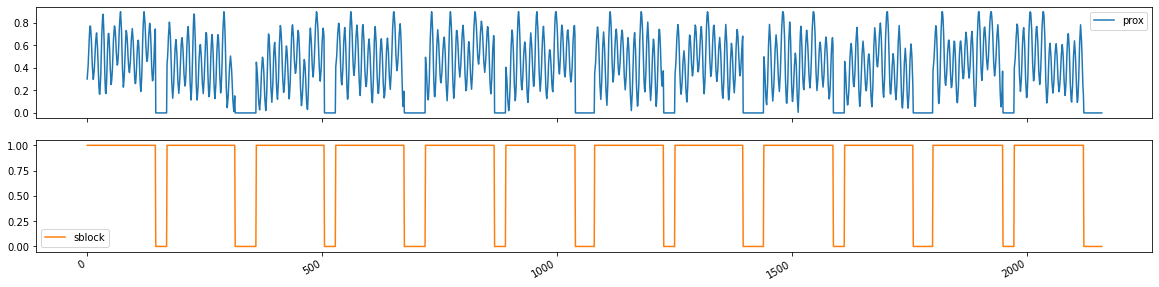

In [9]:
exp_df.loc[:,['prox','sblock']].plot(subplots=True,figsize=(20,5))

# Predict

In [10]:
predictions = []
for ts in range(proximity.shape[0]-7):
    ts_window = whole_brain_ts[:,ts:ts+7,:]
    predictions.append('retreat' if model.predict(ts_window)[0][0] > 0.5 else 'approach')

In [11]:
predictions = np.array(predictions)
predictions.shape

(2149,)

In [12]:
prepended_predictions = np.hstack([np.array([predictions[0]]*7), predictions])
print('Length of prediction array: ',len(prepended_predictions))
print('Length of proximity array: ',len(proximity))

Length of prediction array:  2156
Length of proximity array:  2156


(80693, 6)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

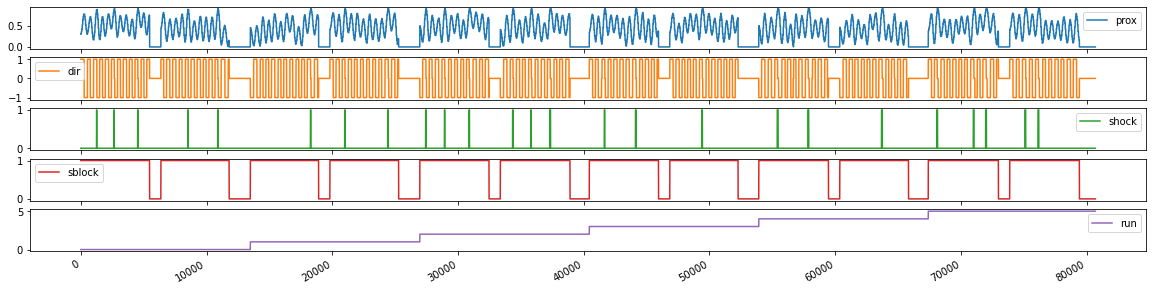

In [13]:
pred_df = pd.DataFrame([prepended_predictions,proximity,direction,sblock,exp_df['run'].values[:-4]],
                       index=['Predictions','prox','dir','sblock','run'],
                       columns=np.arange(len(prepended_predictions))*1.25).T

pred_df.index.name = 'time'
pred_df.index = pd.to_datetime(pred_df.index,unit='s')
pred_df = pred_df.resample('33.383L').pad()
pred_df['shock'] = shock_flags[:shock_flags.shape[0]-1]
print(pred_df.shape)
pred_df[['prox','dir','shock','sblock','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

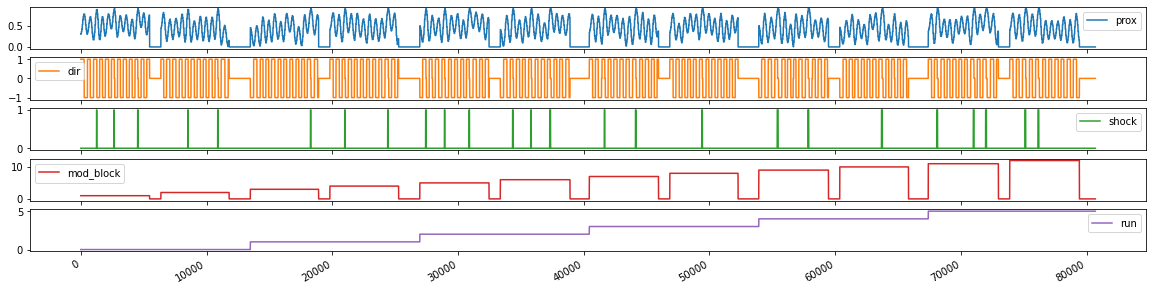

In [14]:
# Add modulated block column so each block can be identified
boxcar = pred_df['sblock']
mod_boxcar = boxcar.copy()
block_num = 1
for i in range(len(boxcar)-1):
    if boxcar[i] == 0. and boxcar[i+1] == 1.:
        block_num += 1
    mod_boxcar[i] = boxcar[i]*block_num
    
pred_df['mod_block'] = mod_boxcar
pred_df[['prox','dir','shock','mod_block','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

Shape:  (79624, 7)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

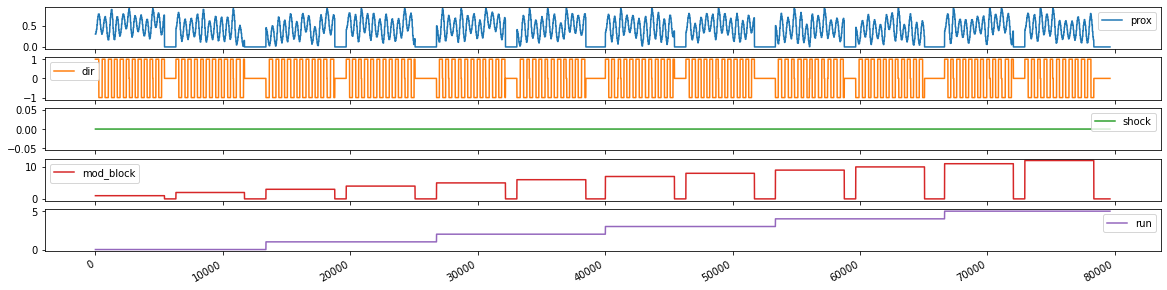

In [15]:
## filter out shocks
pred_df = pred_df[pred_df['shock']==0.0]
print('Shape: ',pred_df.shape)
pred_df[['prox','dir','shock','mod_block','run']].reset_index(drop=True).plot(subplots=True,figsize=(20,5))

In [16]:
# Single Block
def get_block(pred_df, run_num, block_num):
    block_df = pred_df[(pred_df['mod_block']==block_num) & (pred_df['run']==run_num)] # Duration of first run, first block in CON054 is 180s, so roundup(30*180) samples 
    return block_df

In [17]:
from collections import defaultdict
blocks = defaultdict(dict)
for run_num in range(6):
    for block_num in range(1,3):
        b_num = block_num + 2*run_num
        block = get_block(pred_df,run_num,b_num)
        blocks['run%i' %(run_num)]['bl%i' %(block_num-1)] = block
        print('Run %i, block %i: %i' %(run_num, b_num, block.shape[0]))

Run 0, block 1: 5415
Run 0, block 2: 5380
Run 1, block 3: 5402
Run 1, block 4: 5402
Run 2, block 5: 5410
Run 2, block 6: 5410
Run 3, block 7: 5420
Run 3, block 8: 5379
Run 4, block 9: 5404
Run 4, block 10: 5400
Run 5, block 11: 5399
Run 5, block 12: 5414


In [18]:
for r, run in enumerate(blocks):
    for bl, block in enumerate(blocks[run]):
        preds = blocks[run][block].Predictions.values
        dirc = np.array(['approach' if d == 1.0 else 'retreat' for d in blocks[run][block].dir.values])
        if len(preds) < 5400:
            preds = np.append(preds,[preds[-1]]*(5400-len(preds)))
            dirc = np.append(dirc,[dirc[-1]]*(5400-len(dirc)))
        
        np.savetxt(data_path+'/external/{subj}/subj{subj}_run{r}_bl{bl}_pred.txt'.format(subj=subj,
                                                                          r=r, bl=bl),
                   np.array(tuple(zip(preds[:5400],dirc[:5400]))),fmt='%s')
        

In [19]:
y = direction[7:]
print(np.unique(y))
non_zero_idx = y != 0
y = y[non_zero_idx]
print(np.unique(y))
y = (y == 1.).astype(np.float)
print(np.unique(y))

y_pred2 = (np.array(predictions)[non_zero_idx] == 'approach').astype(np.float)

[-1.  0.  1.]
[-1.  1.]
[0. 1.]


## Test Accuracy

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_pred2)

0.6354105998835178

## Chance accuracy if the majority is class is predicted all the time

In [21]:
pd.DataFrame(y).value_counts()

1.0    868
0.0    849
dtype: int64

In [22]:
accuracy_score(y,np.ones(y.shape))

0.5055329062317997